# Make a fit over an entire region of the field

This is a complete example of a fit over an entire region of interest (ROI). The different steps covered are :

1. the extraction of a deep frame and the WCS
2. the definition of the ROI with DS9
3. the fit of a single spectrum in order to get an initial guess on the velocity of the gas
4. the fit of the entire ROI
5. the visualization of the resulting maps

In [1]:
%matplotlib inline
from orcs.process import SpectralCube
import pylab as pl
import orb.utils.io
import numpy as np

In [2]:
cube = SpectralCube('/reductions/sitelle/M57/M57_SN3.merged.cm1.1.0.hdf5')

170829-08:38:43|core:3994:__init__|INFO> Data shape : (2048, 2064, 593)
170829-08:38:43|core:138:__init__|INFO> Cube is in WAVENUMBER (cm-1)
170829-08:38:43|core:145:__init__|INFO> Cube is CALIBRATED


## Export the deep frame with its WCS to define the ROI

Data written as deep_frame.fits in 0.21 s 


'deep_frame.fits'

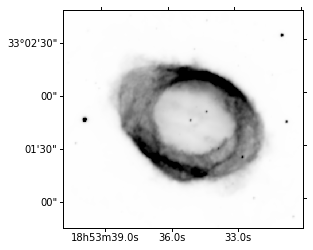

In [15]:
deep_frame = cube.get_deep_frame()
fig = pl.figure()
ax = fig.add_subplot(111, projection=cube.get_wcs())
ax.coords[0].set_major_formatter('hh:mm:ss.s')
ax.coords[1].set_major_formatter('dd:mm:ss')
pl.imshow(deep_frame.T, origin='bottom-left', 
          vmin=np.nanpercentile(deep_frame, 0.1),
          vmax=np.nanpercentile(deep_frame, 99.9),
          cmap='gray_r')
pl.xlim((550,970))
pl.ylim((650,1030))
orb.utils.io.write_fits('deep_frame.fits', deep_frame, fits_header=cube.get_wcs_header(), overwrite=True)

## Use ds9 to define the ROI

from here you can use ds9 to define the region of interest on the deep frame. You can export the region in celestial or image coordinates. Note that the region can also be passed as a collection of pixel position as it is returned by a function such as numpy.nonzero(). the content of the generated ds9 region file is:

It can be plotted (for checking purpose) with pyregion (http://pyregion.readthedocs.io/en/latest/index.html) like this

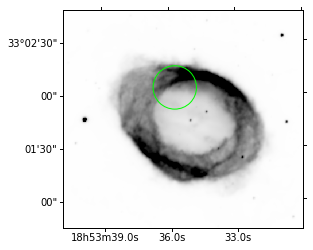

In [5]:
import pyregion

# draw the background image
fig = pl.figure()
ax = fig.add_subplot(111, projection=cube.get_wcs())
ax.coords[0].set_major_formatter('hh:mm:ss.s')
ax.coords[1].set_major_formatter('dd:mm:ss')

pl.imshow(deep_frame.T, origin='bottom-left', 
          vmin=np.nanpercentile(deep_frame, 0.1),
          vmax=np.nanpercentile(deep_frame, 99.9),
          cmap='gray_r')
pl.xlim((550,970))
pl.ylim((650,1030))

# load region file and draw the regions
reg = pyregion.open('region.reg').as_imagecoord(cube.get_wcs_header())

patch_list, artist_list = reg.get_mpl_patches_texts()
for p in patch_list:
    ax.add_patch(p)
for t in artist_list:
    ax.add_artist(t)
    

## Extract a spectrum of the region to define the fit parameters

170828-16:56:27|core:470:_extract_spectrum_from_region|INFO> Number of integrated pixels: 29


 [==========] [100%] [completed in 0.016 s]                                   
Init of the parallel processing server with 16 threads
 [==========] [100%] [completed in 0.369 s]                                   


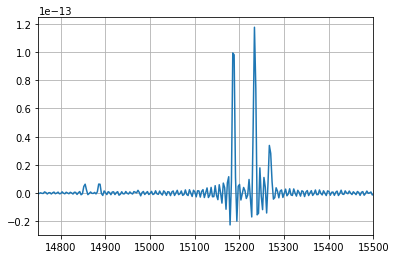

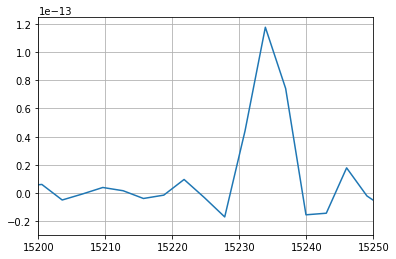

In [4]:
axis, spectrum = cube.extract_spectrum(749, 898, 3)

# all the spectrum
pl.figure()
pl.plot(axis, spectrum)
pl.xlim((14750,15500))
pl.grid()

# zoom over Halpha
pl.figure()
pl.plot(axis, spectrum)
pl.xlim((15200,15250))
pl.grid()


In [3]:
# Halpha wavenumber is roughly 15235 cm-1 which gives a velocity :

import orb.utils.spectrum
from orb.core import Lines
vel = orb.utils.spectrum.compute_radial_velocity(15235, Lines().get_line_cm1('Halpha'), wavenumber=True)
print 'velocity: {} km/s'.format(vel)

velocity: 47.1970433253 km/s


170828-17:05:37|core:470:_extract_spectrum_from_region|INFO> Number of integrated pixels: 29


 [==========] [100%] [completed in 0.029 s]                                   
Init of the parallel processing server with 16 threads
 [==========] [100%] [completed in 0.374 s]                                   
Velocity (km/s):  [58.32(22) 58.32(22) 58.32(22) 58.32(22) 58.32(22)]
Broadening (km/s) [19.14(66) 19.14(66) 19.14(66) 19.14(66) 19.14(66)]


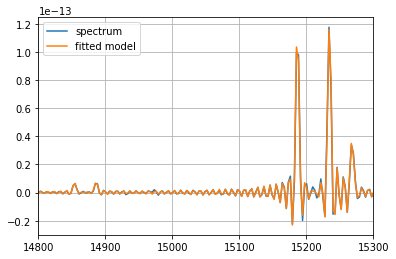

In [4]:
# set up the fit to check if before running the long extraction process over the whole ROI

axis, spectrum, fit = cube.fit_lines_in_spectrum(749, 898, 3, 
                                                 ('[NII]6548', 'Halpha', '[NII]6583', '[SII]6716', '[SII]6731'),
                                                 fmodel='sincgauss', 
                                                 pos_def='1', 
                                                 pos_cov=vel,
                                                 sigma_def='1')

print 'Velocity (km/s): ', fit['velocity_gvar']
print 'Broadening (km/s)', fit['broadening_gvar']
new_vel = fit['velocity'][0]
                                                 
pl.figure()
pl.plot(axis, spectrum, label='spectrum')
pl.plot(axis, fit['fitted_vector'], label='fitted model')
pl.xlim((14800,15300))
pl.legend()
pl.grid()

## Fit the ROI

In [5]:
cube.fit_lines_in_region('region.reg', 
                         ('[NII]6548', 'Halpha', '[NII]6583', '[SII]6716', '[SII]6731'),
                         fmodel='sincgauss', 
                         pos_def='1', 
                         pos_cov=new_vel,
                         sigma_def='1')

170828-17:05:42|kapteyn_celestial:117:longlat2xyz|WARNING> /usr/local/lib/python2.7/dist-packages/pyregion/extern/kapteyn_celestial.py:117: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
  lon = d2r( n.asarray(longlat[:,0],'d').flatten(1) )

170828-17:05:42|kapteyn_celestial:118:longlat2xyz|WARNING> /usr/local/lib/python2.7/dist-packages/pyregion/extern/kapteyn_celestial.py:118: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
  lat = d2r( n.asarray(longlat[:,1],'d').flatten(1) )

170828-17:05:42|kapteyn_celestial:140:xyz2longlat|WARNING> /usr/local/lib/python2.7/dist-packages/pyregion/extern/kapteyn_celestial.py:140: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
  x = n.asarray(xyz[0],'d').flatten(1)

170828-17:05:42|kapteyn_celestial:141:xyz2longlat|WARNING> /usr/local/lib/python2.

 loading region: Shape : circle ( HMS(18:53:35.739),DMS(+33:02:03.821),Ang(12.264") )



170828-17:05:43|core:650:_fit_lines_in_region|WARNING> /home/thomas/Astro/Python/ORB/Orcs/orcs/core.py:650: RuntimeWarning: invalid value encountered in greater
  np.nonzero(np.abs(init_velocity_map_err) > max_vel_err)] = np.nan

170828-17:05:43|core:654:_fit_lines_in_region|WARNING> /home/thomas/Astro/Python/ORB/Orcs/orcs/core.py:654: RuntimeWarning: invalid value encountered in divide
  init_velocity_map /= np.nansum(vel_map_w, axis=2)

170828-17:05:43|core:659:_fit_lines_in_region|WARNING> /home/thomas/Astro/Python/ORB/Orcs/orcs/core.py:659: RuntimeWarning: invalid value encountered in greater
  np.nonzero(np.abs(init_sigma_map_err) > max_sig_err)] = np.nan

170828-17:05:44|core:663:_fit_lines_in_region|WARNING> /home/thomas/Astro/Python/ORB/Orcs/orcs/core.py:663: RuntimeWarning: invalid value encountered in divide
  init_sigma_map /= np.nansum(sig_map_w, axis=2)

170828-17:05:54|core:683:_fit_lines_in_region|INFO> Number of spectra to fit: 4509.0


 [==========] [100%] [completed in 55m38s]                                    

170828-18:01:32|wcs:2561:to_header|WARNING> /usr/local/lib/python2.7/dist-packages/astropy/wcs/wcs.py:2561: AstropyWarning: Some non-standard WCS keywords were excluded: BP_0_0, BP_0_1, BP_0_2, A_3_0, B_3_0, BP_3_0, B_1_2, B_1_0, B_1_1, B_2_1, B_2_0, A_ORDER, B_0_3, B_0_2, B_0_1, B_0_0, BP_0_3, B_ORDER, BP_ORDER, BP_1_2, AP_ORDER, AP_3_0, A_1_1, A_1_0, BP_2_0, A_1_2, AP_2_1, AP_2_0, A_0_0, A_0_1, A_0_2, A_0_3, BP_1_1, BP_1_0, A_2_0, A_2_1, AP_1_0, AP_1_1, AP_1_2, BP_2_1, AP_0_1, AP_0_0, AP_0_3, AP_0_2 Use the ``relax`` kwarg to control this.
  AstropyWarning)




Data written as M57_SN3.1.0.ORCS/MAPS/M57_SN3.1.0.LineMaps.map.6548.1x1.height.fits in 0.19 s 
Data written as M57_SN3.1.0.ORCS/MAPS/M57_SN3.1.0.LineMaps.map.6563.1x1.height.fits in 0.16 s 
Data written as M57_SN3.1.0.ORCS/MAPS/M57_SN3.1.0.LineMaps.map.6583.1x1.height.fits in 0.17 s 
Data written as M57_SN3.1.0.ORCS/MAPS/M57_SN3.1.0.LineMaps.map.6716.1x1.height.fits in 0.18 s 
Data written as M57_SN3.1.0.ORCS/MAPS/M57_SN3.1.0.LineMaps.map.6731.1x1.height.fits in 0.18 s 
Data written as M57_SN3.1.0.ORCS/MAPS/M57_SN3.1.0.LineMaps.map.6548.1x1.height-err.fits in 0.19 s 
Data written as M57_SN3.1.0.ORCS/MAPS/M57_SN3.1.0.LineMaps.map.6563.1x1.height-err.fits in 0.18 s 
Data written as M57_SN3.1.0.ORCS/MAPS/M57_SN3.1.0.LineMaps.map.6583.1x1.height-err.fits in 0.19 s 
Data written as M57_SN3.1.0.ORCS/MAPS/M57_SN3.1.0.LineMaps.map.6716.1x1.height-err.fits in 0.19 s 
Data written as M57_SN3.1.0.ORCS/MAPS/M57_SN3.1.0.LineMaps.map.6731.1x1.height-err.fits in 0.18 s 
Data written as M57_SN3.1.0.O

##  Check the results


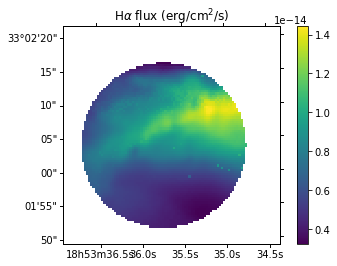

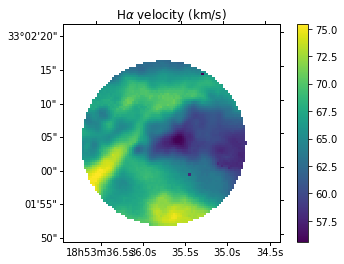

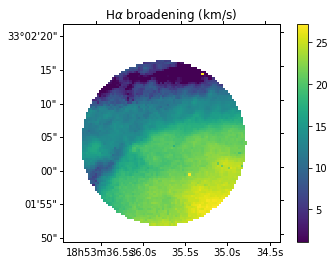

In [6]:
def show_map(path, title):
    fig = pl.figure()
    ax = fig.add_subplot(111, projection=cube.get_wcs())
    ax.coords[0].set_major_formatter('hh:mm:ss.s')
    ax.coords[1].set_major_formatter('dd:mm:ss')
    _map = orb.utils.io.read_fits(path)
    pl.imshow(_map.T, origin='bottom-left', 
              vmin=np.nanpercentile(_map, 0.1),
              vmax=np.nanpercentile(_map, 99.9))
    pl.xlim((700,800))
    pl.ylim((850,950))
    pl.colorbar()
    pl.title(title)
    
show_map('M57_SN3.1.0.ORCS/MAPS/M57_SN3.1.0.LineMaps.map.6563.1x1.flux.fits', r'H$\alpha$ flux (erg/cm$^2$/s)')
show_map('M57_SN3.1.0.ORCS/MAPS/M57_SN3.1.0.LineMaps.map.6583.1x1.velocity.fits', r'H$\alpha$ velocity (km/s)')
show_map('M57_SN3.1.0.ORCS/MAPS/M57_SN3.1.0.LineMaps.map.6583.1x1.sigma.fits', r'H$\alpha$ broadening (km/s)')
